In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from nltk.stem.snowball import SnowballStemmer
import nltk
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import re

In [2]:
abbr = {
    'ninstagram'        : 'instagram',
    'instagramgram'     : 'instagram',
    'ig'                : 'instagram',
    'strainstagramht'   : 'instagram',
    'insta'             : 'instagram',
    'rinstagramht'      : 'instagram',
    'ninstagramguh'     : 'instagram',
    'instagramz'        : 'instagram',
    'sinstagramn'       : 'instagram',
    'binstagramgest'    : 'instagram',
    'pinstagram'        : 'instagram',
    'linstagramht'      : 'instagram',
    'ninstagramg'       : 'instagram',
    'instagramh'        : 'instagram',
    'instagramnor'      : 'instagram',
    'ninstagramht'      : 'instagram',
    'ninstagramgramga'  : 'instagram',
    'finstagramht'      : 'instagram',
    'binstagram'        : 'instagram',
    'hinstagramh'       : 'instagram',
    'ninstagramga'      : 'instagram',
    'toninstagramht'    : 'instagram',
    'minstagramht'      : 'instagram',
    'minstagramt'       : 'instagram',
    'dwn'               : 'down',
    'dawn'              : 'down',
    'ta'                : 'that',
    'dat'               : 'that',
    'dawg'              : 'dude',
    'smh'               : 'head',
    'fr'                : 'real',
    'plz'               : 'please',
    'tf'                : 'wtf',
    'theyr'             : 'are',
    'bc'                : 'because',
    'af'                : 'lot',
    'u'                 : 'you',
    'ppl'               : 'people',
    'dm'                : 'message',
    'bf'                : 'friend',
    'gt'                : 'getting',
    'ya'                : 'yes',
    'na'                : 'no',
    'ur'                : 'your',
    'tryna'             : 'to',
    'lmfao'             : 'lmao',
    'ive'               : 'have'
}

In [3]:
def remove_points(line):
    l = list(line)

    for i in range(len(l)):
        if i < len(l) - 2 and l[i] == '.' and 'A' <= l[i+2] <= 'Z':
            l[i] = ' '

    line = ' '.join(l)

In [4]:
def reduce_repetition(s):
    # Use regular expression to find repeated substrings
    pattern = re.compile(r'(.+?)\1{%d,}' % 2)
    match = pattern.search(s)

    # Reduce repetition to two occurrences
    while match:
        repeated_substring = match.group(1)
        s = s.replace(match.group(), repeated_substring, 1)
        match = pattern.search(s)

    return s

In [5]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import nltk
import re


lemmatizer = WordNetLemmatizer()

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

def preprocess(sentence, get='stems'):
    sent = re.sub(r'@([a-zA-Z0-9_]+)', 'username', sentence).replace('username:', '') # replace first username
    sent = re.sub(r'http?://\S+', 'weblink', sent)
    sent = re.sub(r'&amp', '&', sent)

    if sent and sent[0] == '.':
        sent = sent[1:]

    remove_points(sent)
    sent = sent   .replace('RT', '').replace('!', ' ').replace('"', '').replace("\n", ' ')\
                        .replace(';', ' ').replace('-', ' ').replace(' and ', ' & ').replace('\'', '')\
                        .replace('?', '.').replace(',', '').replace('~', ' ').replace('|', ' ').replace('°', ' ')\
                        .replace('`', ' ').replace('~', ' ').replace('*', ' ').replace('+', ' ').replace('/', ' ')\
                        .replace(' # ', ' ').replace('http', ' ').replace('t.co', ' ').replace('\\', ' ').replace('&#', ' ')
    for _ in range(4):
        sent = sent.replace('  ', ' ').replace('..', '.').replace(' .', '.') # remove multiple points & space
    
    if sent and sent[0] == ' ':
        sent = sent[1:]

    sent = sent.lower()

    for old in abbr:
        new = abbr[old]
        sent = sent.replace( ' ' + old + ' ', ' ' + new + ' ' ) # add some space arround the world to avoid matching a part of a word

    sent = reduce_repetition(sent)

    if get == 'sentence':
        return sent
    
    tokens = nltk.word_tokenize(sent)

    for i in range(len(tokens) - 1, 0, -1):
        if len(tokens[i].strip()) == 0 or (len(tokens[i].strip()) == 1 and tokens[i].strip() != 'a' and tokens[i].strip() != 'i' and tokens[i].strip() != '&'):
            tokens.pop(i)

    if get == 'tokens':
        return tokens

    stems = [lemmatizer.lemmatize(tok, get_wordnet_pos(tok)) for tok in tokens]

    return stems


In [6]:
dataset_path = './archive/train.csv'
data_column  = 'tweet'
SVM			 = False

In [7]:
import pandas as pd

df = pd.read_csv(dataset_path)

In [8]:
df['processed_text'] = df[data_column].apply(preprocess)

In [9]:
from gensim.models import Word2Vec
import numpy as np

# Train a Word2Vec model on your tokens
word2vec_model = Word2Vec(sentences=df['processed_text'], vector_size=100, window=5, min_count=1, workers=4)

# Generate averaged word vector features
def document_vector(word2vec_model, doc):
    # remove out-of-vocabulary words
    doc = [word for word in doc if word in word2vec_model.wv]
    return np.mean(word2vec_model.wv[doc], axis=0)

X_word2vec = np.array([document_vector(word2vec_model, doc) for doc in df['processed_text']])


In [10]:
df['processed_text_str'] = df['processed_text'].apply(lambda x: " ".join(x))

# Then apply TF-IDF vectorization on the resulting strings
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf_vectorizer.fit_transform(df['processed_text_str']).toarray()

In [11]:
def label_tweet(row):
    """
    - Hate: If hate_speech_count is the highest count.
    - Offensive: If offensive_language_count is the highest count.
    - Hate & Offensive: If hate_speech_count and offensive_language_count are equal and higher than neither_count.
    - Neither: If neither_count is the highest count.
    """
    if row['hate_speech_count'] > row['offensive_language_count'] and row['hate_speech_count'] > row['neither_count']:
        return 'hate'
    elif row['offensive_language_count'] > row['hate_speech_count'] and row['offensive_language_count'] > row['neither_count']:
        return 'offensive'
    elif row['hate_speech_count'] == row['offensive_language_count'] and row['hate_speech_count'] > row['neither_count']:
        return 'hate_offensive'
    else:
        return 'neither'

In [12]:
df['label'] = df.apply(label_tweet, axis=1)

In [13]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['label'])

In [14]:
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print(label_mapping)

{'hate': 0, 'neither': 1, 'offensive': 2}


In [15]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Grid search for parameter optimization
param_grid = {'n_estimators': [50, 100, 200, 300], 'max_depth': [5, 10, 15, 20]}
grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=5)
grid_search.fit(X_train, y_train)

print("Best parameters: ", grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

# Train model with best parameters
best_rf_model = grid_search.best_estimator_

Best parameters:  {'max_depth': 15, 'n_estimators': 100}
Best cross-validation score: 0.78


In [17]:
from sklearn.model_selection import cross_val_score

cross_val_scores = cross_val_score(best_rf_model, X_tfidf, y, cv=5)
print("Average cross-validation score: {:.2f}".format(np.mean(cross_val_scores)))

Average cross-validation score: 0.78


In [18]:
import seaborn as sns

def plot_confusion_matrix(cm, class_names):

    figure = plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap=plt.cm.Blues, cbar=False,
                xticklabels=class_names, yticklabels=class_names)
    plt.title("Confusion Matrix")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    return figure

In [21]:
# True labels, already known as y_test from your train_test_split operation
true_labels = y_test

# Predicted labels, which you get by making predictions on your test set
predicted_labels = best_rf_model.predict(X_test)

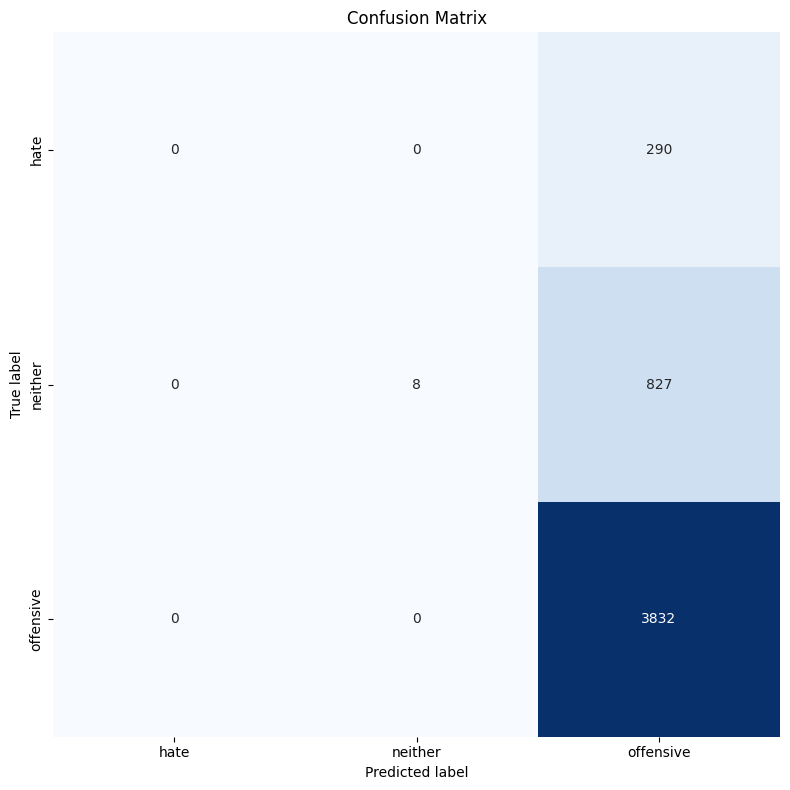

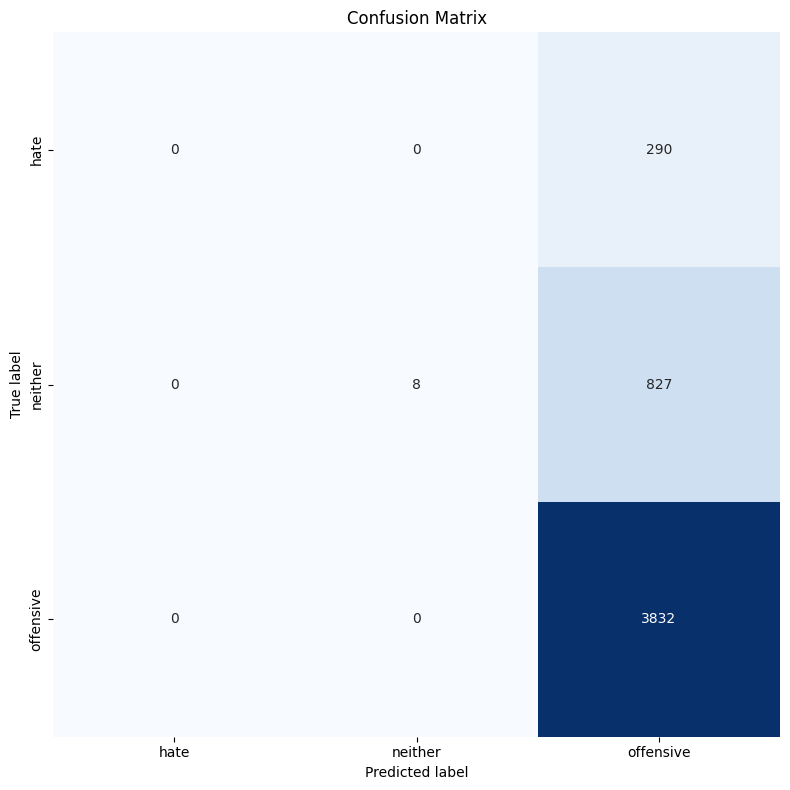

In [22]:
cm = confusion_matrix(true_labels, predicted_labels)
plot_confusion_matrix(cm, label_mapping.keys())